In [2]:
from scripts.imports import os, glob, pdb, np, h5py, pd, xr, gpd, Proj, Transformer, CRS, \
                        plt, cmap, Model, Data, ODR, datetime, rasterio, show, \
                        ccrs, cfeature
from scripts.classes_fixed import *
from scripts.pvpg_fixed import *
from scripts.track_pairs import *

%matplotlib ipympl

/home/s1803229/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# Investigating Quality Flags

A lot of these flags are showing me the same information in different ways for the problem track. I am also aware that the quality assessment flags are likely focused on the entire track, not just the section I am looking at, making them slightly less useful for focused analysis.

| Data Product (ATL--) | Flag | Values | Description | Purpose |
| :-: | :-: | :-: | :- | :- |
| 03 | gt1r/geolocation/ph_index_beg | Integer | List of index of first photon with a segment, used in conjuction with segment_ph_cnt | In problem track there were first photons listed as zero, didn't occur in good track. There were also many more photons per segment in problem track. |
| 03 | gt1r/geolocation/segment_ph_cnt | Integer | Number of photons in a given 20m along-track segment | Problem track once again had several zero values, corresponding to 0s in ph_index_beg. Didn't occur in good track. |
| 03 | gt1r/geolocation/reference_photon_index | counts | Index of reference photon within the set of photons in a segment. | Position of reference photon is ref_ph_ndex + ph_ndx_beg - 1. Related to segment_ph_cnt, = 0 if no photons in segment. Again shows that number are far too high for the problem track. |
| 03 | gt1r/geophys_corr/dem_flag | [0,...,4] | Indicates source of the DEM height: 0 = None, 1 = Arctic, 2 = GMTED, 3 = MSS, 4 = Antarctic. | In the tracks I looked at, the problem track had 0s in problem sections and the good tracks did not. |
| 03 | /quality_assessment/gt1r/qa_perc_signal_conf_ph_high | Percentage (1 x 5) | Percentage of high-confidence signal photons for each surface type, based on the total number of photons for each surface type. | The problem track had a clear lower percentage of high confidence photons than the two good control tracks. For referance, the surface types are (land, ocean, seaice, landice, inlandwater). Problem track is clearly lower confidence on land (and on almost all surface types). |
| 03 | /quality_assessment/gt1r/qa_perc_signal_conf_ph_low | Percentage (1 x 5) | Percentage of low-confidence signal photons for each surface type, absed on total number of photons for each surface type. | There was a slight increase in four of the numbers, but unclear in the fourth percentage number. Analysis would need to be done to see if statistically signfiicant. In the land category, the problem track is only slightly worse. |
| 03 | /quality_assessment/gt1r/qa_perc_signal_conf_ph_med | Percentage (1 x 5) | Percentage of mid-confidence signal photons for each surface type, absed on total number of photons for each surface type. | There was a noticeably larger number in the land and inland water categories, but the other three numbers made it virtually unseperable from the good control tracks. Not recommended to be used for quality flagging. |
| 03 | /quality_assessment/gt1r/qa_perc_surf_type | Percentage (1 x 5) | Percentage of geolocation segments for each surface type, based on total number of geolocation segments. |
| 08 | /gt1r/land_segments/asr | Float | Apparent surface reflectance for each 100m land segment. | I am curious if this could be used at all to see snow. Additionally, it's not ridiculous to think of its use for flag, as the problem track had a few 0 values that the control tracks did not. |
| 08 | /gt1r/land_segments/brightness_flag | [0, 1] | Indicates that the ground surface is bright, i.e. 1 is a bright surface. | Doesn't seem that useful at a glance, for flagging or for FSC. |
| 08 | /gt1r/land_segments/cloud_flag_atm | [0, ..., 10] | Cloud confidence flag indiciating the number of cloud or aerosol layers identified in each 25Hz atmopsheric profile. | Slightly more aerosols present in the problem track, but only barely. Would need to be investigated further. |
| 08 | /gt1r/land_segments/layer_flag | [0, 1] | Combination of cloud_flag_atm, cloud_flag_asr, and bsnow_con and takes daytime/nighttime into consideration. 1 indicates likely cloudy (cloud or blowing snow), 0 indicates likely clear. | Identified problem track as likely cloudy and control tracks as likely clear. Possibly useful, but we don't want to just get rid of all cloudy tracks. More analysis needed comparing problem tracks and control tracks. |
| 08 | /gt1r/land_segments/msw_flag | [-1, ..., 5] | 0 means no multiple scattering, 5 is greatest multiple scattering. Flag meanings are [cannot determine, no layers, height of bottom of layer >3km, height of bottom of layer between 1km and 3km, layer lower than 1km, blowing snow with optical depth less than 0.5, blowing snow with optical depth greater than 0.5]. | Hard to tell, all of problem track is 1, part of one of control tracks is 1. Less useful than other flags in throwing out tracks, more useful for stratifying. |
| 08 | /gt1r/land_segments/n_seg_ph | Integer | Number of photons within each land segment. | Number of photon counts is far, far higher for the problem track. Probably not as useful as other flags. |
| 08 | /gt1r/land_segments/segment_landcover | Integer | Copernicus Land Cover classification at 100m resolution for the 100m segment. | This could be useful in future modeling to adjust the model by the landcover type. The SCAMod model uses a similar concept to approximate transmissivity for different land cover types. We could use the land cover type a a feature in a model. This would require identification of control areas to train a model for each landcover type. |
| 08 | /gt1r/land_segments/canopy/subset_can_flag | 5 Integers | Quality flag indicating the canopy photons populating the 100m segment. [-1 0 1] means ['no_photon_data_in_segment', 'no_canopy_photons_in_segment', 'canopy_photons_exist_in_segment']. | This looks fairly directly like a quality flag. |
| 08 | /gt1r/land_segments/terrain/subset_te_flag | 5 Integers | Quality flag indicating the ground photons populating the 100m segment. [-1 0 1] means ['no_photon_data_in_segment', 'no_ground_photons_in_segment', 'ground_photons_exist_in_segment']. | Similar deal to row above. |

In the function pvpg_flagged, we use ph_index_beg as our flag.

/home/s1803229/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


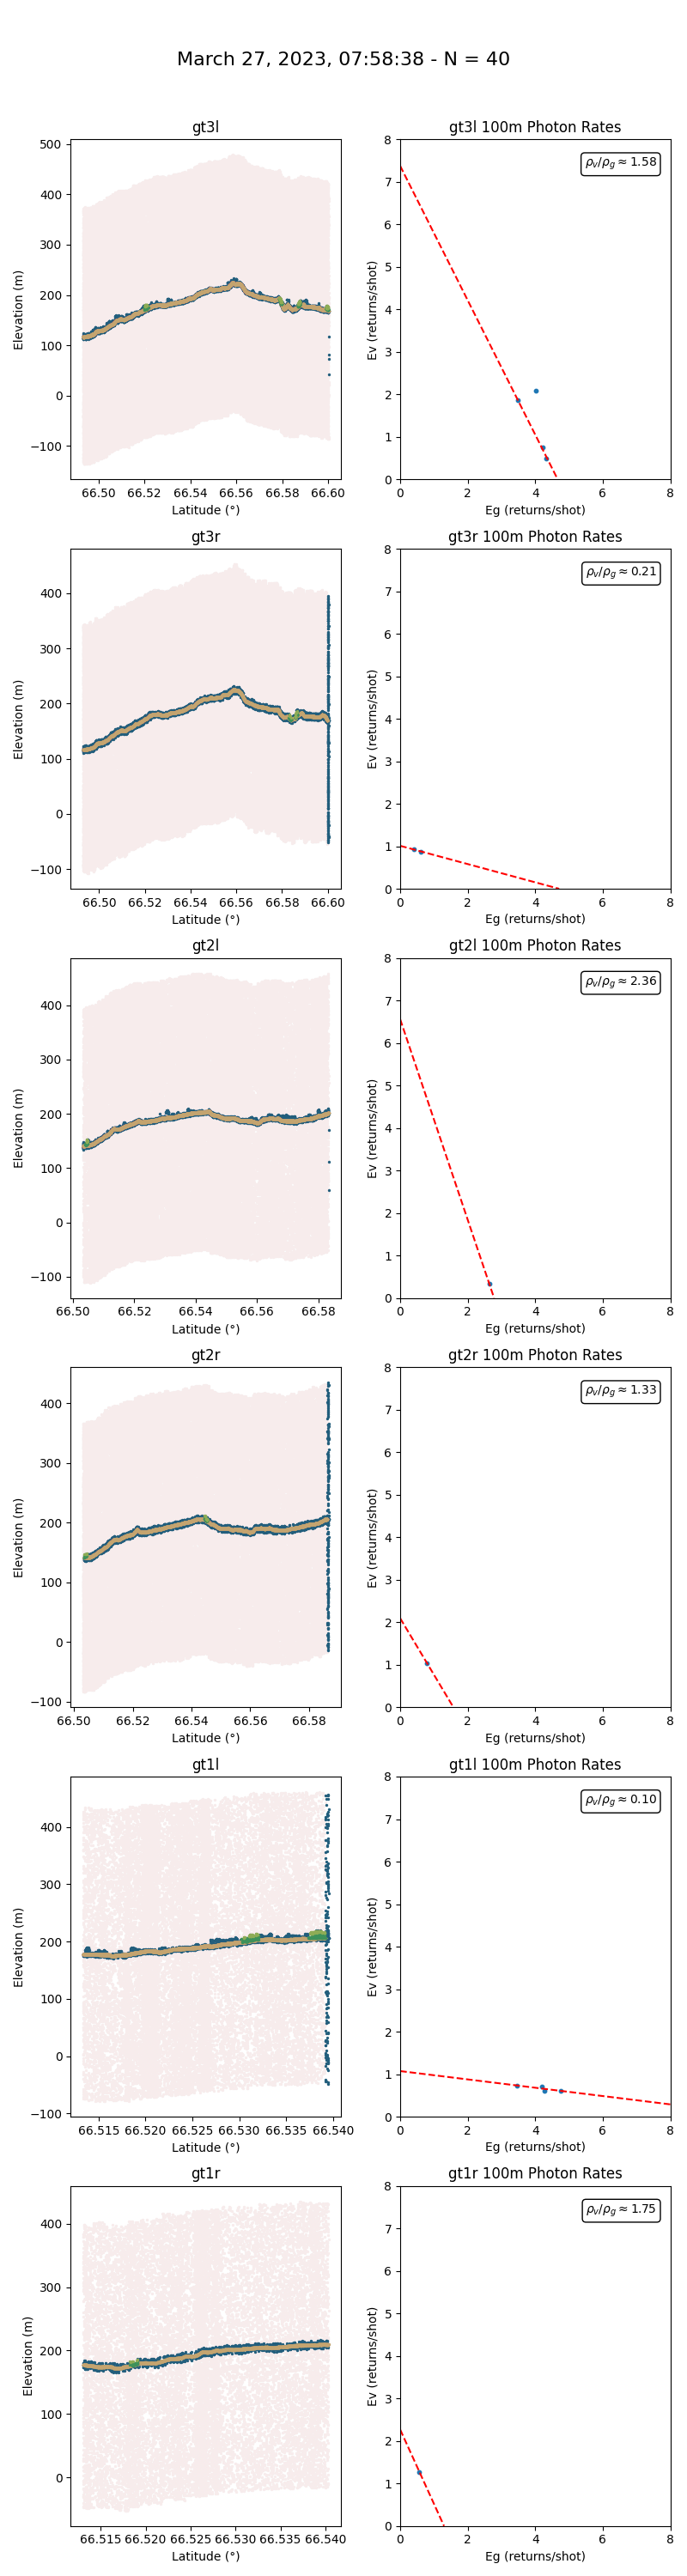

File 41 has been skipped.


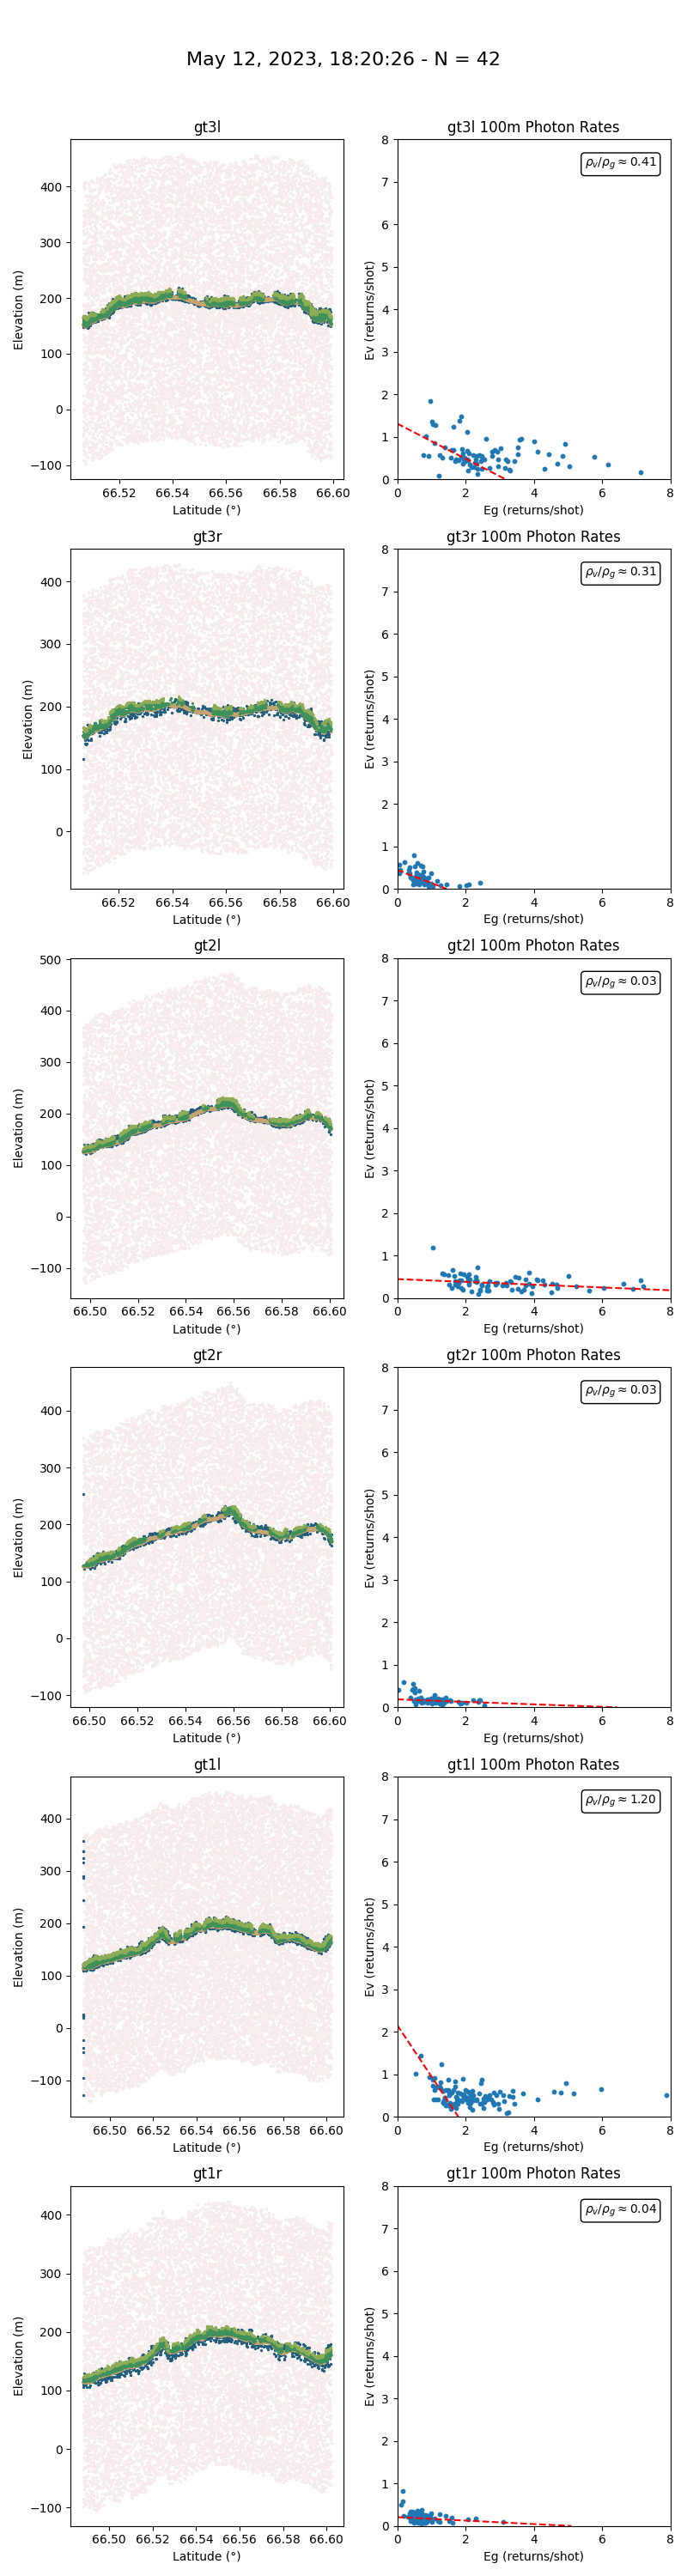

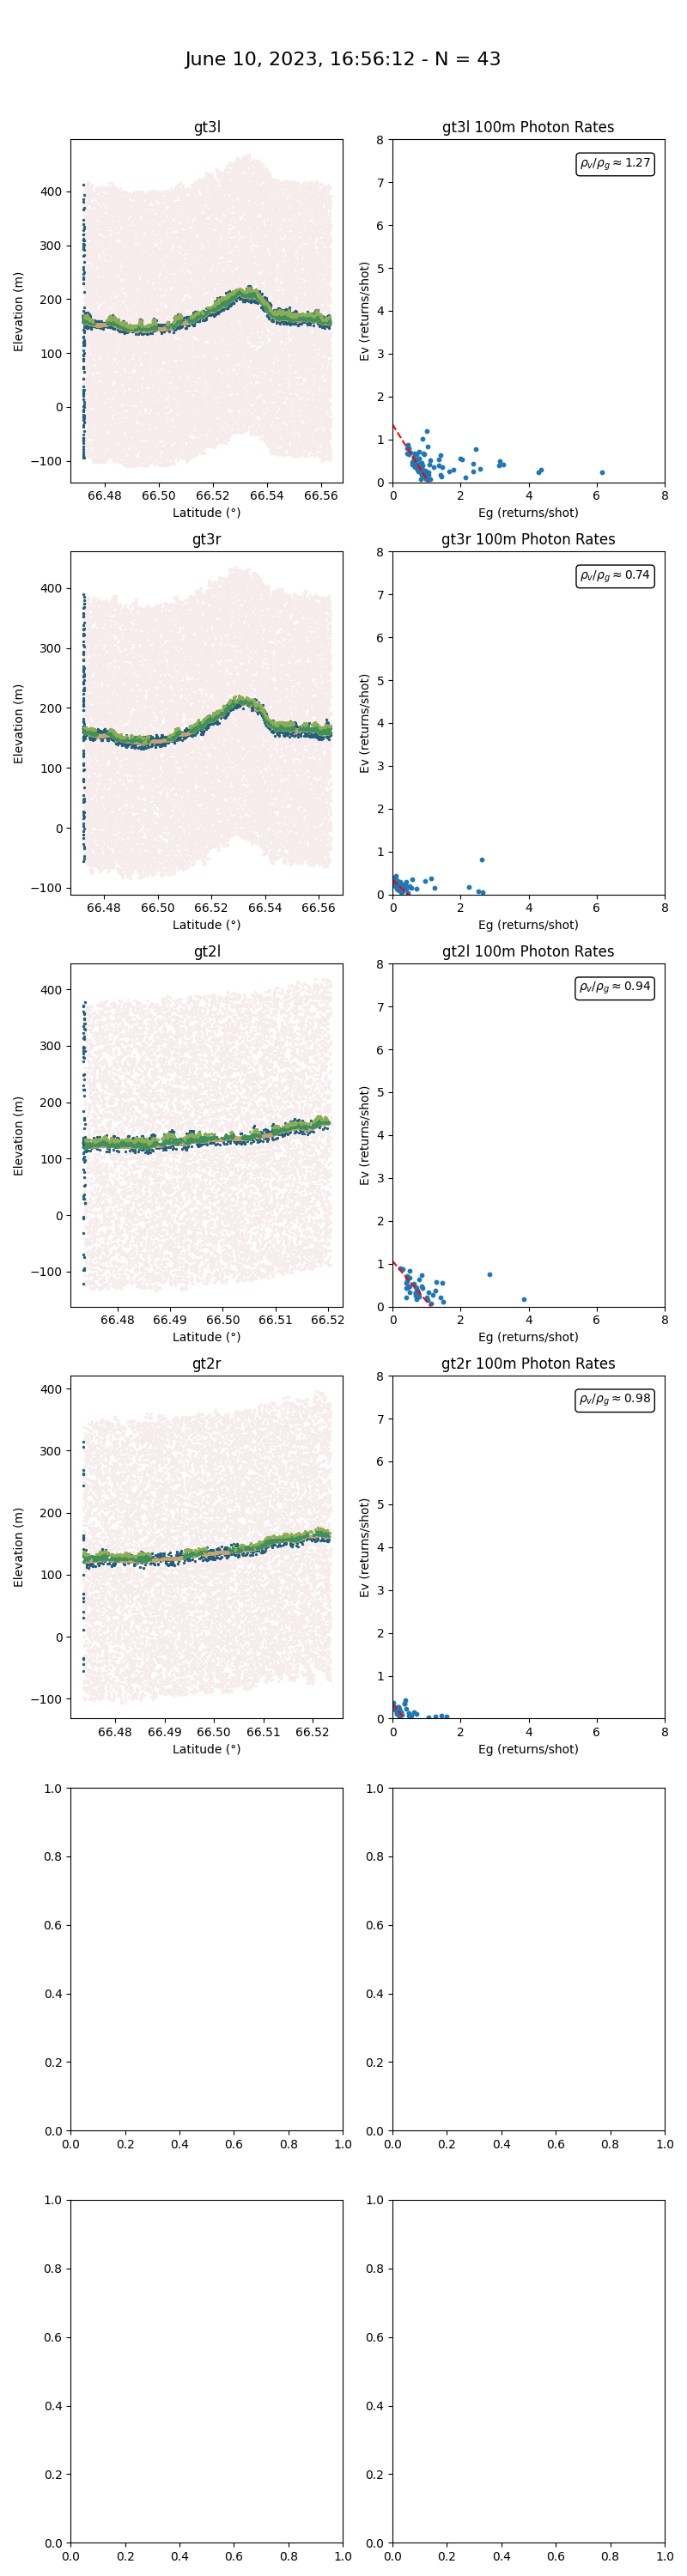

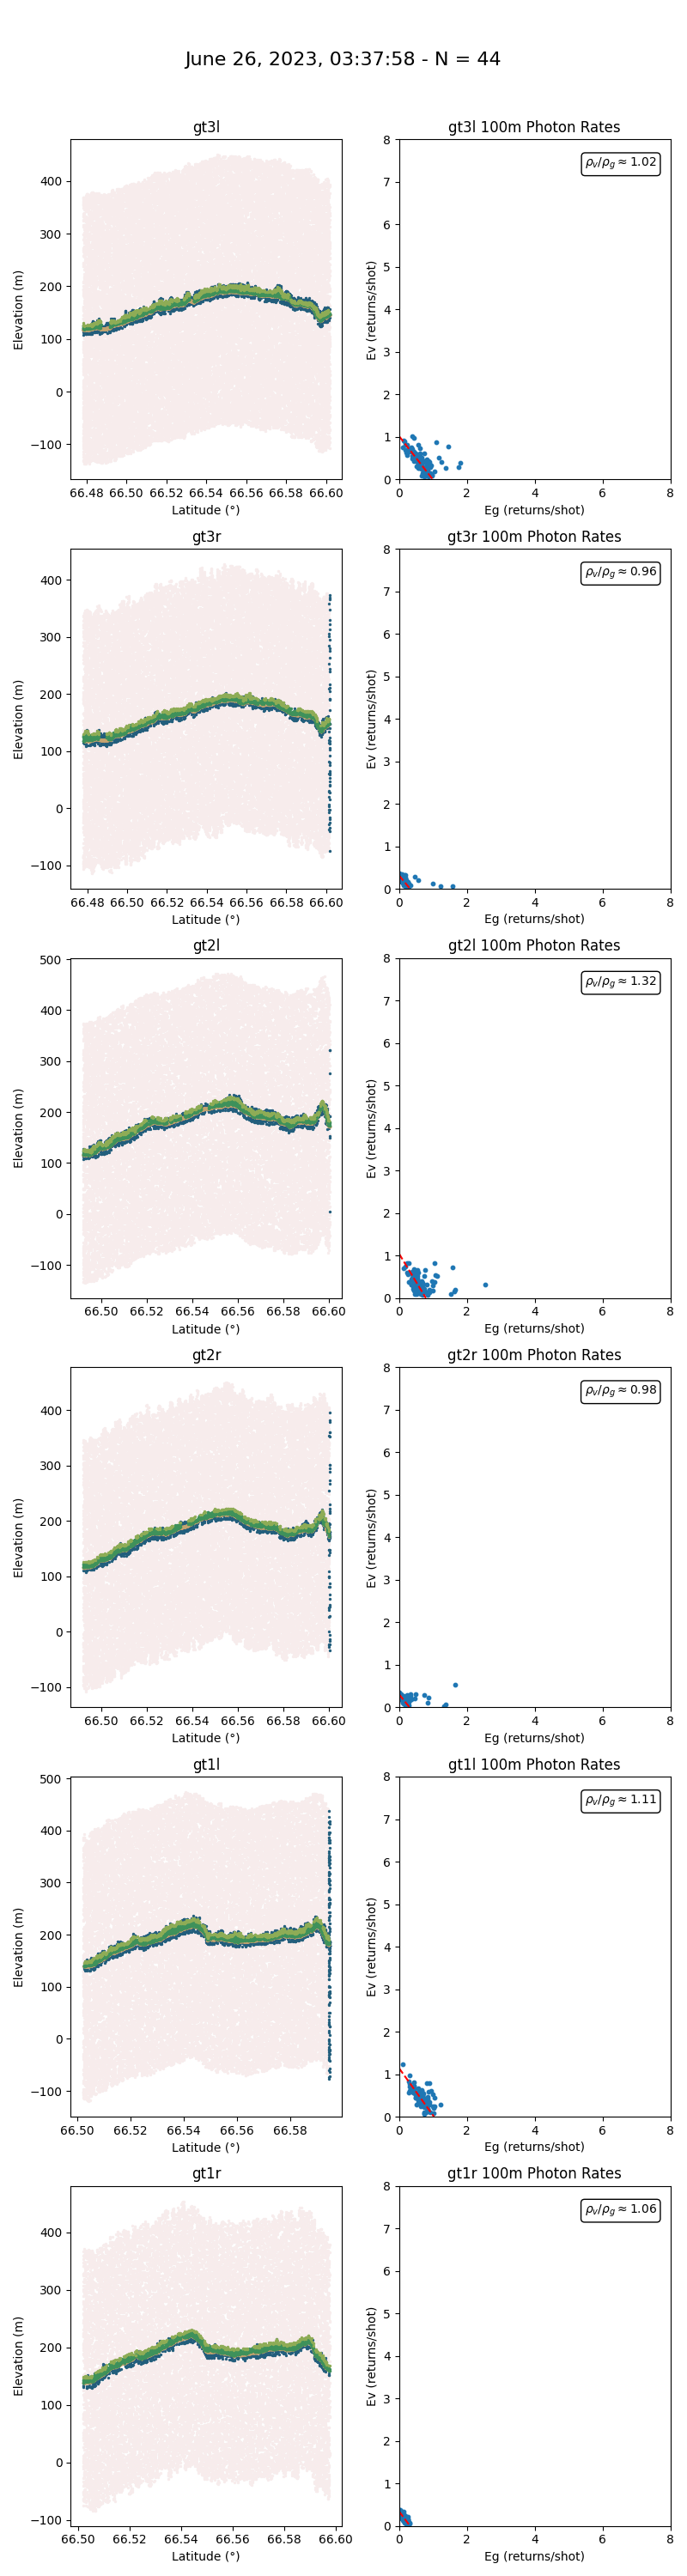

File 45 has been skipped.


In [2]:
from scripts.imports import os, glob, pdb, np, h5py, pd, xr, gpd, Proj, Transformer, CRS, \
                        plt, cmap, Model, Data, ODR, datetime, rasterio, show, \
                        ccrs, cfeature
from scripts.classes_fixed import *
from scripts.pvpg_fixed import *
from scripts.track_pairs import *

%matplotlib ipympl

dirpath = '../data/rovaniemi_w'
all_ATL03, all_ATL08 = track_pairs(dirpath)

N = len(all_ATL03)
for i in range(N-6,N):
    pvpg_penalized_flagged(all_ATL03[i], all_ATL08[i], file_index=i, loss='arctan')